# XGBoost Classifier for S&P 500 Direction Prediction

This notebook uses the combined S&P 500 dataset (2020-2025) to train an XGBoost Classifier for market direction prediction.

The model will predict whether the S&P 500 will go up (1) or down (0) the next day based on technical indicators.

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from ta.trend import MACD
import matplotlib.pyplot as plt

In [2]:
# 1. Load S&P 500 data from combined CSV
df = pd.read_csv("../Dataset/SP500_combined_2020-2025.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort by date in chronological order (oldest to newest)
df = df.sort_index()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print("\nColumns available:")
print(df.columns.tolist())
print("\nFirst few rows (oldest dates):")
print(df.head())
print("\nLast few rows (newest dates):")
print(df.tail())

# Verify chronological order
print(f"\n✅ Data is sorted chronologically: {df.index.is_monotonic_increasing}")
print(f"Total trading days: {len(df)}")

Dataset shape: (1398, 5)
Date range: 2020-01-02 00:00:00 to 2025-07-25 00:00:00

Columns available:
['Open', 'High', 'Low', 'Close', 'source_file']

First few rows (oldest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2020-01-02  3,244.67  3,258.14  3,235.53  3,257.85  1_01012020 to 12312020.csv
2020-01-03  3,226.36  3,246.15  3,222.34  3,234.85  1_01012020 to 12312020.csv
2020-01-06  3,217.55  3,246.84  3,214.64  3,246.28  1_01012020 to 12312020.csv
2020-01-07  3,241.86  3,244.91  3,232.43  3,237.18  1_01012020 to 12312020.csv
2020-01-08  3,238.59  3,267.07  3,236.67  3,253.05  1_01012020 to 12312020.csv

Last few rows (newest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2025-07-21  6,304.74  6,336.08  6,303.79  6,305.60  6_01012025 to 25072025.csv

In [3]:
# 2. Clean and convert numeric columns
# Remove commas and convert to float for all price columns
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

for col in price_columns:
    if col in df.columns:
        # Convert to string first, remove commas, then convert to float
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Convert Volume to numeric (remove commas if present)
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)

print("Data types after conversion:")
print(df.dtypes)
print("\nPrice data sample:")
print(df[['Open', 'High', 'Low', 'Close']].head())

Data types after conversion:
Open           float64
High           float64
Low            float64
Close          float64
source_file     object
dtype: object

Price data sample:
               Open     High      Low    Close
Date                                          
2020-01-02  3244.67  3258.14  3235.53  3257.85
2020-01-03  3226.36  3246.15  3222.34  3234.85
2020-01-06  3217.55  3246.84  3214.64  3246.28
2020-01-07  3241.86  3244.91  3232.43  3237.18
2020-01-08  3238.59  3267.07  3236.67  3253.05


In [4]:
# 2. Create technical indicators
df["rsi"] = RSIIndicator(close=df["Close"], window=14).rsi()
df["sma_10"] = SMAIndicator(close=df["Close"], window=10).sma_indicator()
df["ema_5"] = EMAIndicator(close=df["Close"], window=5).ema_indicator()

# Create MACD indicator
macd_indicator = MACD(close=df["Close"])
df["macd"] = macd_indicator.macd()

# Create target variable (market direction)
df["target_up_down"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Drop rows with NaN values
df.dropna(inplace=True)

print("Technical indicators created:")
print(f"RSI range: {df['rsi'].min():.2f} - {df['rsi'].max():.2f}")
print(f"Target distribution: {df['target_up_down'].value_counts().sort_index()}")

Technical indicators created:
RSI range: 18.11 - 82.90
Target distribution: target_up_down
0    631
1    742
Name: count, dtype: int64


In [5]:
# 3. Prepare features and target
X = df[["rsi", "macd", "sma_10", "ema_5"]]
y = df["target_up_down"]  # 1 if price goes up, 0 if down

# Train/test split (preserve time order)
X_train, X_test = X.iloc[:-100], X.iloc[-100:]
y_train, y_test = y.iloc[:-100], y.iloc[-100:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# 4. Train XGBoost Classifier
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Make predictions
predictions = model.predict(X_test)

# 6. Evaluate the model
print("\n=== Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Training set size: 1273
Test set size: 100

=== Model Evaluation ===
Accuracy: 0.4400

Confusion Matrix:
[[18 22]
 [34 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.45      0.39        40
           1       0.54      0.43      0.48        60

    accuracy                           0.44       100
   macro avg       0.44      0.44      0.44       100
weighted avg       0.46      0.44      0.45       100


=== Model Evaluation ===
Accuracy: 0.4400

Confusion Matrix:
[[18 22]
 [34 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.45      0.39        40
           1       0.54      0.43      0.48        60

    accuracy                           0.44       100
   macro avg       0.44      0.44      0.44       100
weighted avg       0.46      0.44      0.45       100



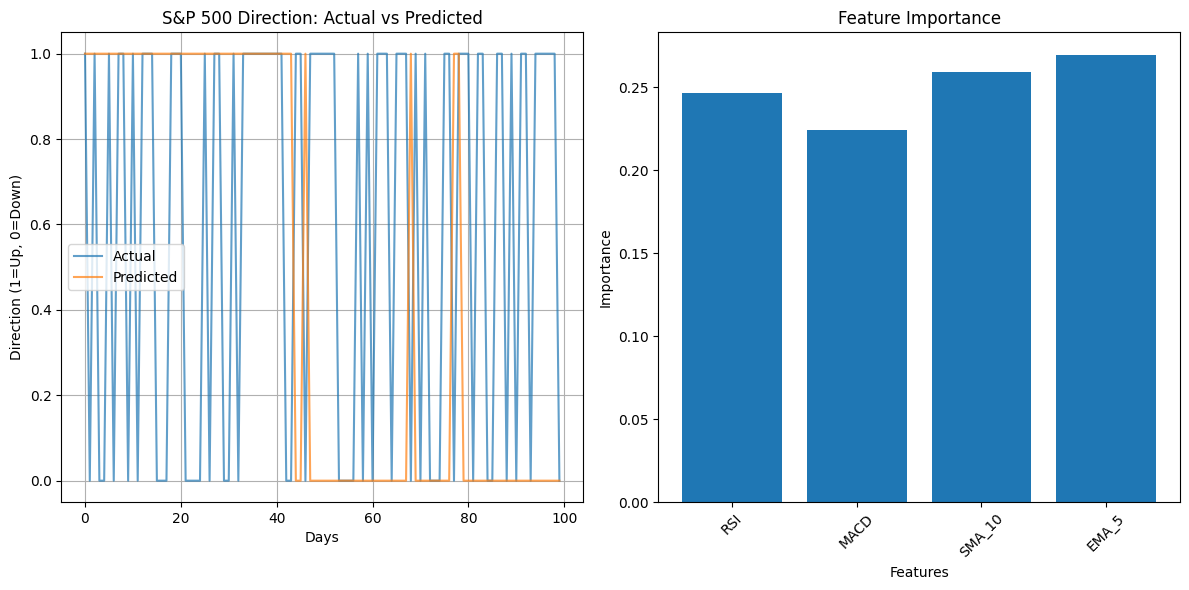

In [6]:
# 7. Visualize results
plt.figure(figsize=(12, 6))

# Plot actual vs predicted
plt.subplot(1, 2, 1)
plt.plot(range(len(y_test)), y_test.values, label="Actual", alpha=0.7)
plt.plot(range(len(predictions)), predictions, label="Predicted", alpha=0.7)
plt.title("S&P 500 Direction: Actual vs Predicted")
plt.xlabel("Days")
plt.ylabel("Direction (1=Up, 0=Down)")
plt.legend()
plt.grid(True)

# Plot feature importance
plt.subplot(1, 2, 2)
feature_importance = model.feature_importances_
features = ["RSI", "MACD", "SMA_10", "EMA_5"]
plt.bar(features, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()